# FNO Model Inference Demo - Helmholtz Equation

This notebook demonstrates how to load a pretrained FNO (Fourier Neural Operator) model and perform inference on Helmholtz equation data.

The model was trained using `TrainFNO.py` with 1024 training samples on the Helmholtz equation benchmark.

## Helmholtz Equation
The Helmholtz equation solved is: ∇²u + ω²a²u = 0
- Input: Coefficient field a(x,y) and boundary condition bc
- Output: Solution field u(x,y)
- Domain: [0,1] × [0,1] on 128×128 grid
- Frequency: ω = 5π/2

## FNO Data Format
Note: FNO uses [H, W, C] data format (height × width × channels) compared to CNO's [C, H, W] format.


## 1. Import Required Libraries


In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import DataLoader
import os
import sys

# set the path of the script to the project for all cells
sys.path.append('..')

# Import the necessary modules for FNO
from Problems.FNOBenchmarks import Helmholtz

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
print(f'PyTorch version: {torch.__version__}')


Using device: cpu
PyTorch version: 2.7.1+cu126


## 2. Load Model Configuration and Pretrained Weights

In [4]:
'''
Some useful model folder paths:
(Trained) "../TrainedModels/helmholtz/FNO_1024helmholtz"
(With pretraining) "../TrainedModels/helmholtz/PINO_FNO_pretrainedhelmholtz"
(No pretraining) "../TrainedModels/helmholtz/PINO_FNO_no_pretraininghelmholtz"
(With pretraining improved) "../TrainedModels/helmholtz/PINO+_FNO_pretrainedhelmholtz"
(No pretraining improved) "../TrainedModels/helmholtz/PINO+_FNO_no_pretraininghelmholtz"
'''

# Define model folder path
model_folder = "../TrainedModels/helmholtz/PINO+_FNO_no_pretraininghelmholtz_1"

# Load training properties
training_props_df = pd.read_csv(os.path.join(model_folder, 'training_properties.txt'), 
                               header=None, index_col=0)
training_properties = training_props_df.to_dict()[1]

# Load network architecture (FNO uses different parameters than CNO)
net_arch_df = pd.read_csv(os.path.join(model_folder, 'net_architecture.txt'), 
                         header=None, index_col=0)
model_architecture = net_arch_df.to_dict()[1]

print("Training Properties:")
for key, value in training_properties.items():
    print(f"  {key}: {value}")

print("\\nFNO Architecture:")
for key, value in model_architecture.items():
    print(f"  {key}: {value}")


Training Properties:
  learning_rate: 0.0003
  weight_decay: 1e-10
  scheduler_step: 10.0
  scheduler_gamma: 0.98
  epochs: 100.0
  batch_size: 16.0
  exp: 3.0
  training_samples: 1024.0
  lambda: 1.0
  boundary_weight: 10.0
  pad_factor: 0.0
  patience: 0.4
\nFNO Architecture:
  width: 128
  modes: 16
  FourierF: 0
  n_layers: 4
  padding: 0
  include_grid: 1
  retrain: 4


In [5]:
# Load the pretrained FNO model
model_path = os.path.join(model_folder, 'model.pkl')

# Fix for PyTorch 2.6+ - need to set weights_only=False for full model loading
# This is safe since we trust the source of this model file
model = torch.load(model_path, map_location=device, weights_only=False)

# Fix device mismatch: ensure model's internal device matches current device
if hasattr(model, 'device'):
    model.device = device
model = model.to(device)
model.eval()  # Set to evaluation mode

print(f"FNO model loaded successfully from {model_path}")
print(f"Model is on device: {next(model.parameters()).device}")

# Print model summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


FNO model loaded successfully from ../TrainedModels/helmholtz/PINO+_FNO_no_pretraininghelmholtz_1/model.pkl
Model is on device: cpu
Total parameters: 33,654,273
Trainable parameters: 33,654,273


## 3. Setup Data Loaders

We'll create data loaders for the Helmholtz equation using the same configuration as during FNO training.


In [6]:
# Extract parameters for data loading
batch_size = int(training_properties['batch_size'])
training_samples = int(training_properties['training_samples'])
pad_factor = int(training_properties.get('pad_factor', 0))

# FNO typically uses 128x128 for Helmholtz equation
grid_size = 128

# Create the Helmholtz data loader using FNO benchmarks
helmholtz_data = Helmholtz(
    network_properties=model_architecture,
    device=device,
    batch_size=batch_size,
    training_samples=training_samples,
    s=grid_size,
    in_dist=True,  # In-distribution test data
    N_max=19675,   # Total samples in dataset
    cluster=True,  # Running on cluster
    pad_factor=pad_factor
)

print(f"FNO Data loaders created:")
print(f"  Training samples: {len(helmholtz_data.train_loader.dataset)}")
print(f"  Validation samples: {len(helmholtz_data.val_loader.dataset)}")
print(f"  Test samples: {len(helmholtz_data.test_loader.dataset)}")
print(f"  Grid resolution: {grid_size}x{grid_size}")
print(f"  Batch size: {batch_size}")
print(f"  Pad factor: {pad_factor}")


FNO Data loaders created:
  Training samples: 1024
  Validation samples: 256
  Test samples: 256
  Grid resolution: 128x128
  Batch size: 16
  Pad factor: 0


## 4. Single Sample Inference Example

Let's perform inference on a single sample and visualize the results. Note that FNO uses a different data format [H×W×C] compared to CNO's [C×H×W].

For Helmholtz data:
- Input has 2 channels: coefficient field a(x,y)-1 and boundary condition bc
- Output is the solution field u(x,y)


In [7]:
cmap = 'gist_ncar'  # Good colormap for visualization


In [8]:
# Get a single sample from test data
test_iter = iter(helmholtz_data.test_loader)
input_batch, output_batch = next(test_iter)

# Move to device
input_batch = input_batch.to(device)
output_batch = output_batch.to(device)

print(f"FNO Input batch shape: {input_batch.shape}")  # FNO uses [B, H, W, C] format
print(f"FNO Output batch shape: {output_batch.shape}")

# Perform inference
with torch.no_grad():
    prediction_batch = model(input_batch)

# Convert to numpy for plotting (take first sample from batch)
# FNO data format: [H, W, C], so we take different channels for different fields
coefficient_field = input_batch[0, :, :, 0].cpu().numpy()  # First channel (coefficient field a-1)
boundary_condition = input_batch[0, :, :, 1].cpu().numpy()  # Second channel (boundary condition)
ground_truth = output_batch[0, :, :, 0].cpu().numpy()      # Solution field
prediction = prediction_batch[0, :, :, 0].cpu().numpy()

print(f"Coefficient field shape: {coefficient_field.shape}")
print(f"Boundary condition shape: {boundary_condition.shape}")
print(f"Ground truth shape: {ground_truth.shape}")
print(f"Prediction shape: {prediction.shape}")

# Print some statistics
print(f"\\nData statistics:")
print(f"  Coefficient field range: [{coefficient_field.min():.4f}, {coefficient_field.max():.4f}]")
print(f"  Boundary condition: {boundary_condition[0,0]:.4f}")  # Should be constant
print(f"  Ground truth range: [{ground_truth.min():.4f}, {ground_truth.max():.4f}]")
print(f"  Prediction range: [{prediction.min():.4f}, {prediction.max():.4f}]")


FNO Input batch shape: torch.Size([16, 128, 128, 2])
FNO Output batch shape: torch.Size([16, 128, 128, 1])
Coefficient field shape: (128, 128)
Boundary condition shape: (128, 128)
Ground truth shape: (128, 128)
Prediction shape: (128, 128)
\nData statistics:
  Coefficient field range: [0.0000, 1.0000]
  Boundary condition: 0.3594
  Ground truth range: [-3.7307, 3.1431]
  Prediction range: [-1.8055, 2.4067]


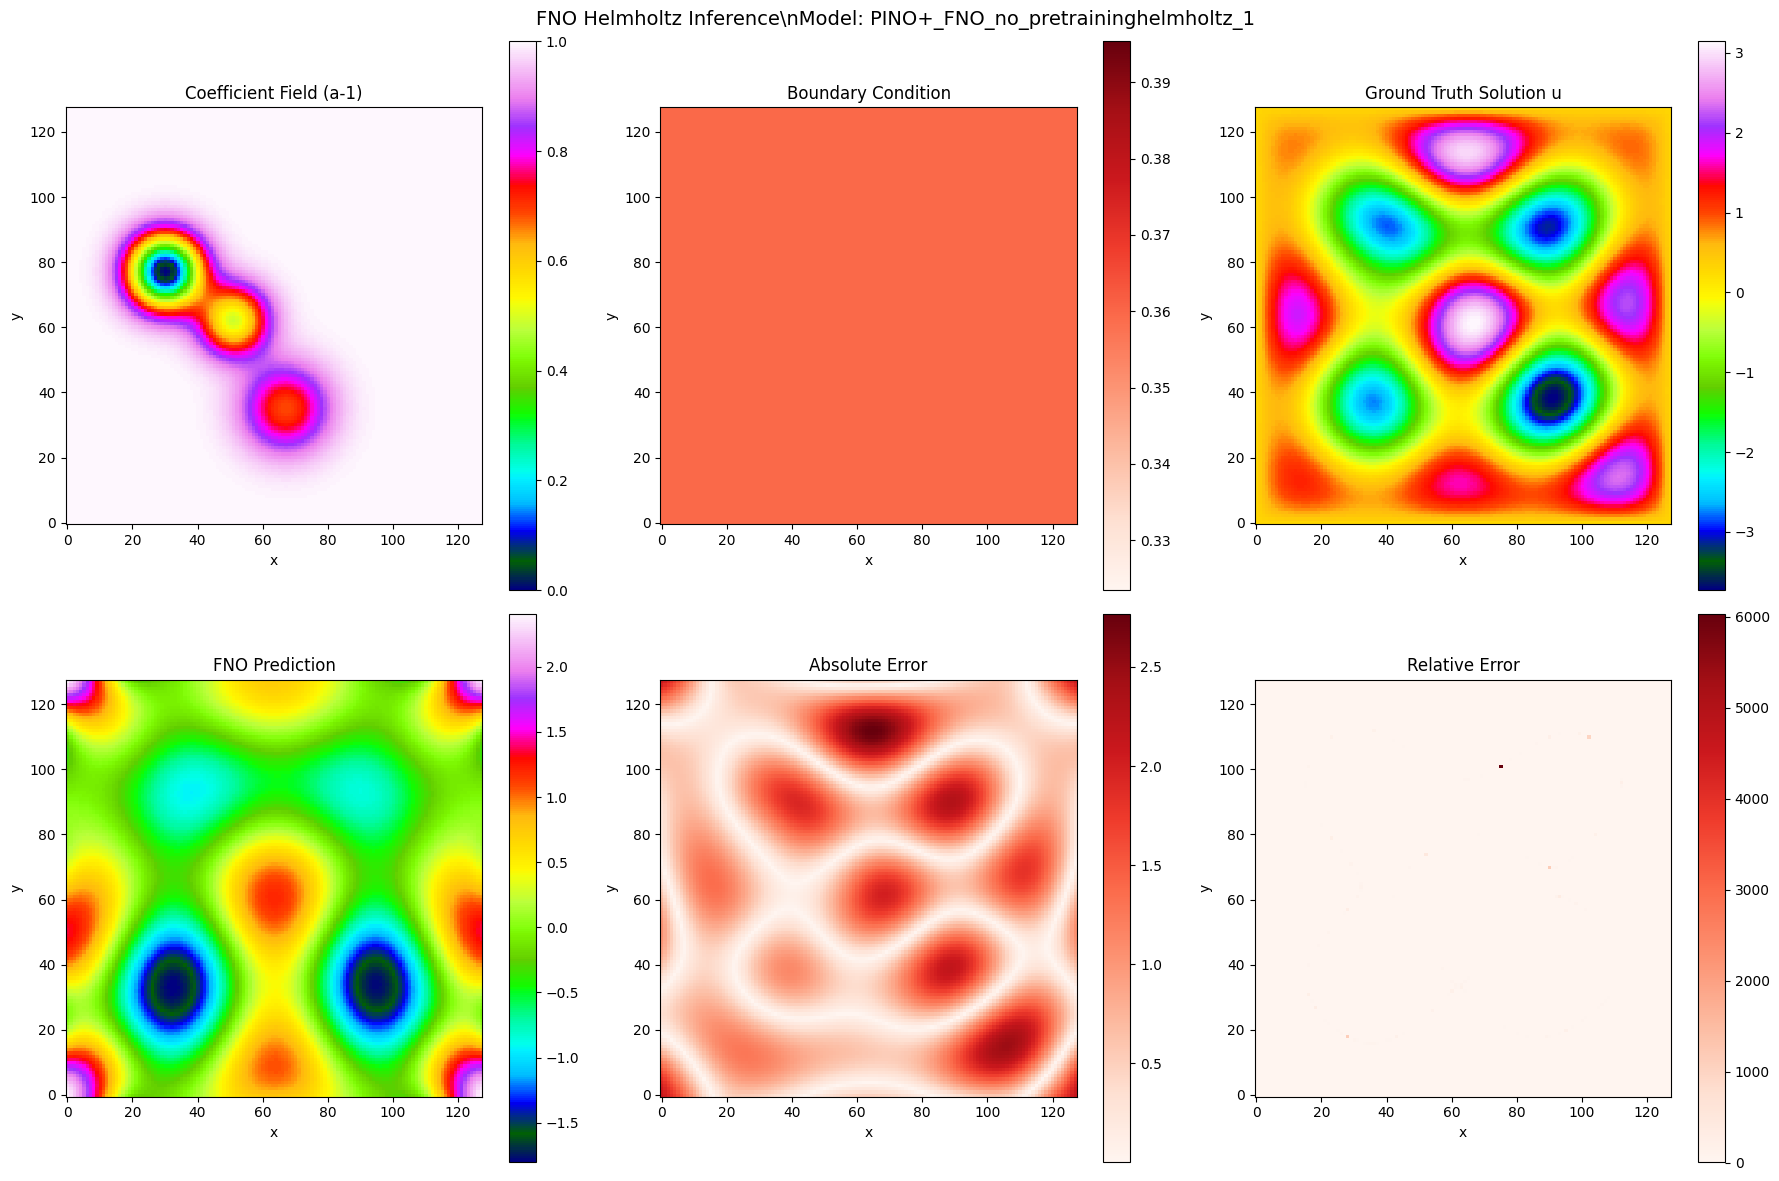

Relative L2 error for this sample: 0.7397 (73.97%)


In [9]:
# Visualize the results for Helmholtz equation
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Add model folder path as title
fig.suptitle(f"FNO Helmholtz Inference\\nModel: {model_folder.split('/')[-1]}", fontsize=14)

# Coefficient field (a-1)
im1 = axes[0, 0].imshow(coefficient_field, cmap=cmap, origin='lower')
axes[0, 0].set_title('Coefficient Field (a-1)')
axes[0, 0].set_xlabel('x')
axes[0, 0].set_ylabel('y')
plt.colorbar(im1, ax=axes[0, 0])

# Boundary condition field
im2 = axes[0, 1].imshow(boundary_condition, cmap='Reds', origin='lower')
axes[0, 1].set_title('Boundary Condition')
axes[0, 1].set_xlabel('x')
axes[0, 1].set_ylabel('y')
plt.colorbar(im2, ax=axes[0, 1])

# Ground truth solution
im3 = axes[0, 2].imshow(ground_truth, cmap=cmap, origin='lower')
axes[0, 2].set_title('Ground Truth Solution u')
axes[0, 2].set_xlabel('x')
axes[0, 2].set_ylabel('y')
plt.colorbar(im3, ax=axes[0, 2])

# FNO prediction
im4 = axes[1, 0].imshow(prediction, cmap=cmap, origin='lower')
axes[1, 0].set_title('FNO Prediction')
axes[1, 0].set_xlabel('x')
axes[1, 0].set_ylabel('y')
plt.colorbar(im4, ax=axes[1, 0])

# Error map
error = np.abs(ground_truth - prediction)
im5 = axes[1, 1].imshow(error, cmap='Reds', origin='lower')
axes[1, 1].set_title('Absolute Error')
axes[1, 1].set_xlabel('x')
axes[1, 1].set_ylabel('y')
plt.colorbar(im5, ax=axes[1, 1])

# Relative error map (avoid division by zero)
rel_error_map = np.abs(ground_truth - prediction) / (np.abs(ground_truth) + 1e-8)
im6 = axes[1, 2].imshow(rel_error_map, cmap='Reds', origin='lower')
axes[1, 2].set_title('Relative Error')
axes[1, 2].set_xlabel('x')
axes[1, 2].set_ylabel('y')
plt.colorbar(im6, ax=axes[1, 2])

plt.tight_layout()
plt.show()

# Calculate relative error for this sample
rel_error = np.linalg.norm(ground_truth - prediction) / np.linalg.norm(ground_truth)
print(f"Relative L2 error for this sample: {rel_error:.4f} ({rel_error*100:.2f}%)")


## 5. Multiple Sample Visualization

Let's visualize FNO predictions on multiple Helmholtz samples to get a better sense of model performance across different coefficient fields and boundary conditions.


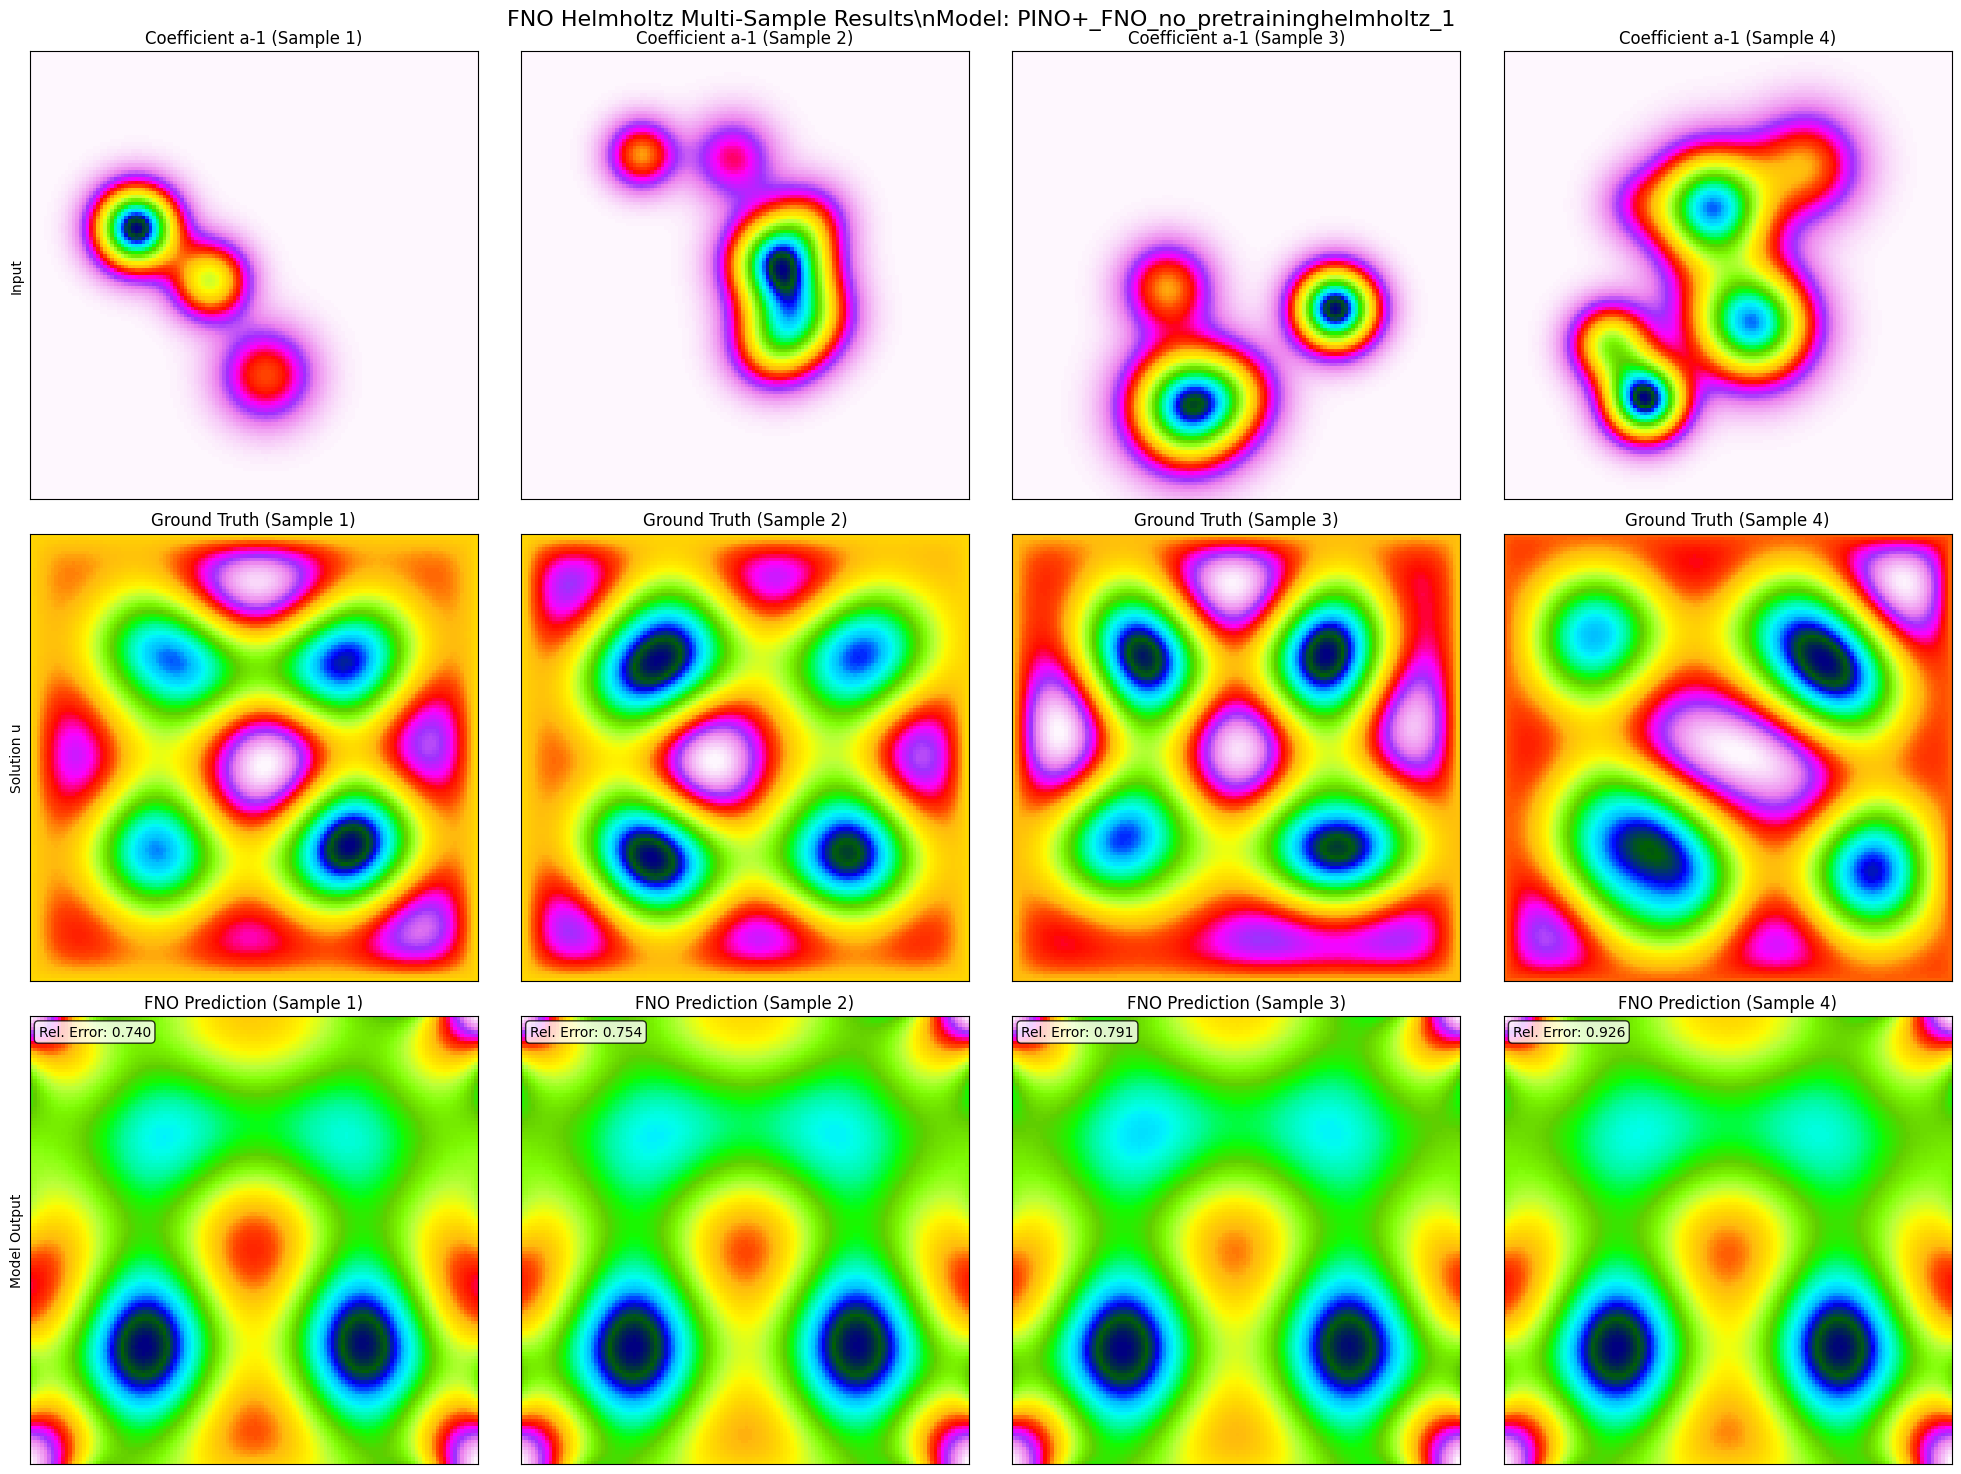

In [10]:
# Get multiple samples for visualization
num_samples = 4
test_iter = iter(helmholtz_data.test_loader)
input_batch, output_batch = next(test_iter)

# Take first few samples
input_batch = input_batch[:num_samples].to(device)
output_batch = output_batch[:num_samples].to(device)

# Get predictions
with torch.no_grad():
    prediction_batch = model(input_batch)

# Create visualization showing coefficient field, ground truth, and prediction
fig, axes = plt.subplots(3, num_samples, figsize=(20, 15))

# Add model folder path as title
fig.suptitle(f"FNO Helmholtz Multi-Sample Results\\nModel: {model_folder.split('/')[-1]}", fontsize=16)

for i in range(num_samples):
    # Convert to numpy (note FNO format: [H, W, C])
    coefficient_field = input_batch[i, :, :, 0].cpu().numpy()
    ground_truth = output_batch[i, :, :, 0].cpu().numpy()
    prediction = prediction_batch[i, :, :, 0].cpu().numpy()
    
    # Plot coefficient field
    im1 = axes[0, i].imshow(coefficient_field, cmap=cmap, origin='lower')
    axes[0, i].set_title(f'Coefficient a-1 (Sample {i+1})')
    if i == 0:
        axes[0, i].set_ylabel('Input')
    
    # Plot ground truth
    im2 = axes[1, i].imshow(ground_truth, cmap=cmap, origin='lower')
    axes[1, i].set_title(f'Ground Truth (Sample {i+1})')
    if i == 0:
        axes[1, i].set_ylabel('Solution u')
    
    # Plot prediction
    im3 = axes[2, i].imshow(prediction, cmap=cmap, origin='lower')
    axes[2, i].set_title(f'FNO Prediction (Sample {i+1})')
    if i == 0:
        axes[2, i].set_ylabel('Model Output')
    
    # Calculate and display relative error
    rel_error = np.linalg.norm(ground_truth - prediction) / np.linalg.norm(ground_truth)
    axes[2, i].text(0.02, 0.98, f'Rel. Error: {rel_error:.3f}', 
                   transform=axes[2, i].transAxes, 
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                   verticalalignment='top')

# Remove axis ticks for cleaner look
for ax in axes.flat:
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()
